In [1]:
from pandas import read_excel
import numpy as np
from numpy.linalg import eigh
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.pyplot.ion()
%matplotlib inline 
import pickle

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import QUBO_to_Ising, find_offset, AnnealOffset

from qlp.tdse import (
    s_to_offset,
    AnnealSchedule,
    TDSE,
    embed_qubo_example,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw

In [13]:
# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
result = dict()
offset_min_list = [-0.05] #-0.01 * np.arange(6)
for offset_min in offset_min_list:
    print(offset_min)
    graph, tag = gt.generate_nn_graph(2)
    penalty = 2
    embed = False  # If true, does NN(2) only.

    annealing_time = 1  # microseconds

    offset = "binary"
    fill_value = "truncate"  # "extrapolate" or "truncate"
    offset_min = offset_min
    offset_range = -2 * offset_min

    solver_params = dict()
    solver_params["method"] = "RK45"
    solver_params["rtol"] = 1e-6
    solver_params["atol"] = 1e-7

    tdse_solve = False
    initial_wavefunction = "true"  # "true" or "dwave"

    """Start Program"""
    # get qubo
    if embed:
        qubo = embed_qubo_example()
    else:
        directed = False
        qubo = get_mds_qubo(
            graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
        )
    # print("QUBO")
    # print(qubo.todense())

    # number of qubits
    n = len(qubo.todense())

    # convert to Ising
    # Jij MUST BE upper triangular
    Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())
    
    #######################################################################################
    # this is the unit conversion of energy/time (since we set time interval to be [0,1])
    #######################################################################################

    # assume annealing_time unit in microsecond and energy unit in Ghz
    def energyscaleconversion(annealing_time):
        return annealing_time * 1000.0 / (2.0 * np.pi)

    energyscale = energyscaleconversion(annealing_time)

    ising_params = {"Jij": Jij, "hi": hi, "c": c, "energyscale": energyscale}
    offset_params = {
        "offset": offset,
        "offset_min": offset_min,
        "offset_range": offset_range,
        "fill_value": fill_value,
    }

    # print("Ising")
    # print(Jij)
    # print(hi)
    # print(energyscale)

    # plot graph
    # gt.get_plot(graph, directed=directed)
    # plt.show()
    # initial state
    xev = np.asarray([1.0 / np.sqrt(2.0), 1.0 / np.sqrt(2.0)])
    y0 = xev[:]
    for i in range(n - 1):
        y0 = np.kron(xev, y0)
    y0 = (1.0 + 0.0j) * y0  # ensure complex dtype
    # print('initial state',y0)

    # solve ode
    tdse = TDSE(n, ising_params, offset_params)
    if tdse_solve:
        if initial_wavefunction == "true":
            # true ground state
            eigvalue, eigvector = eigh(tdse.annealingH(s=0))
        elif initial_wavefunction == "dwave":
            # DWave initial wave function
            eigvalue, eigvector = eigh(
                -0.5
                * energyscale
                * tdse.constructtransverseH(tdse.AS.A(0) * np.ones(n))
            )
        y1 = (1.0 + 0.0j) * eigvector[:, 0]
        # print("Initial wavefunction")
        # print(y1)

        sol = solve_ivp(tdse, [0.0, 1.0], y1, **solver_params)

        # print('ode solution')
        # for i in range(sol.t.size):
        #    print('time',i,'=',sol.t[i])
        #    print(sol.y[:,i])

        # brute force diagonalization Ising hamiltonain

        energy, eigv = np.linalg.eigh(tdse.IsingH)
        mask = [str(energy[0])[:10] == str(i)[:10] for i in energy]
        ground_state_idx = np.arange(len(energy))[mask]
        # print('brute force Ising')
        # print('eigen envergy',energy)
        # print('eigen vector')
        # print(eigv)

        # plot probability overlap with Ising ground state
        overlap = np.zeros(sol.t.size)
        for i in range(sol.t.size):
            overlap[i] = sum(np.absolute([np.dot(eigv[:, idx], sol.y[:, i]) for idx in ground_state_idx])**2)
        with open(
            f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle",
            "wb",
        ) as file:
            rpickle = dict()
            rpickle["tdse"] = tdse
            rpickle["sol"] = sol
            rpickle["overlap"] = overlap
            pickle.dump(rpickle, file)

-0.05


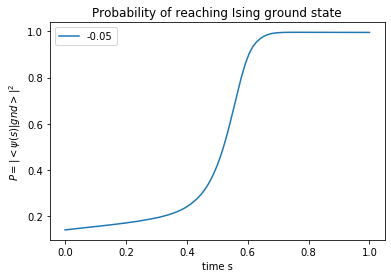

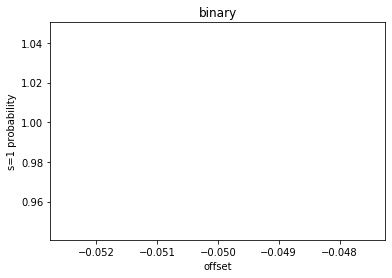

In [15]:
result = dict()
proba = dict()
plt.figure("prob(s)")
ax = plt.axes()
for offset_min in offset_min_list:
    with open(f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle", "rb") as file:
        rpickle = pickle.load(file)
        result[offset_min] = rpickle["tdse"]
        proba[offset_min] = rpickle["overlap"][-1]
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["overlap"], label=offset_min)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'$P= |<\psi (s) | gnd >|^2$')
plt.title('Probability of reaching Ising ground state')
plt.show()

plt.figure("prob final")
ax=plt.axes()
ax.errorbar(x=list(proba.keys()), y=list(proba.values()))
ax.set_xlabel('offset')
ax.set_ylabel('s=1 probability')
plt.title(offset)
plt.show()

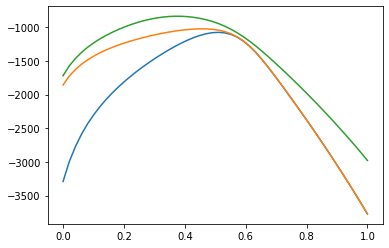

In [19]:
fig = plt.figure()
ax = plt.axes()
gap = dict()
for key in result.keys():
    x = []
    y0 = []
    y1 = []
    y2=[]
    for s in np.linspace(0, 1):
        eigval, eigvec = eigh(result[key].annealingH(s))
        seigval = np.sort(eigval)
        x.append(s)
        y0.append(seigval[0])
        y1.append(seigval[1])
        y2.append(seigval[2])
    ax.errorbar(x=x, y=y0)
    ax.errorbar(x=x, y=y1)
    ax.errorbar(x=x, y=y2)
    gap[key] = {0: np.array(y1) - np.array(y0), 1: np.array(y2) - np.array(y0)}
plt.draw()
plt.show()

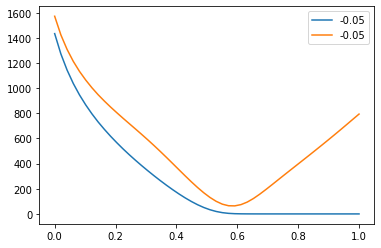

In [20]:
fig = plt.figure()
ax = plt.axes()
for key in gap.keys():
    ax.errorbar(x=x, y=gap[key][0], label=key)
    ax.errorbar(x=x, y=gap[key][1], label=key)
ax.legend()
plt.draw()
plt.show()

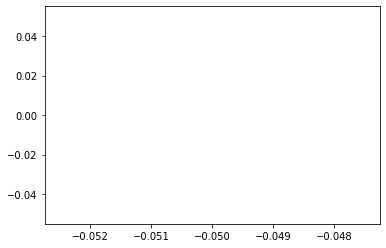

In [21]:
mingap = {key: min(gap[key]) for key in gap.keys()}
plt.figure()
ax = plt.axes()
x = list(mingap.keys())
y=list(mingap.values())
ax.errorbar(x=x,y=y)
plt.draw()
plt.show()